## EXERCISE 2

Visualize and clusterize the data in the file x_12d.dat (N=600 samples, L=12 dimensions), which also has labels for checking the performances (y_12d.dat).

| Name | Surname | ID Number |
|------|---------|---------------------|
| Lucrezia | Rossi | 2122164 |
| Lorenzo | Calandra Buonaura | 2107761 |
| Andrea | Turci | 2106724 |

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN
from sklearn.metrics import normalized_mutual_info_score

### 1\. “eps” (ε) and “minPts” (mP) in DBSCAN algorithm for clustering
Refine the grid with more values of ε and mP and plot a heat-map showing the normalized mutual information (NMI) between true and predicted clusters, similar to the one on the right.

Is the high NMI region showing a correlation between ε and mP?

Note: In the lesson we have looked at the typical distance between a point and its closest neighbor, but this does not say what the typical distance is from the 2nd, 3rd , ..., mP-neighbor. The plots of ranked distances to the i-th neighbor might also help choose the ε for a given i=mP .

In [10]:
fname, fnamey = "x_12d.dat", "y_12d.dat"
data = np.loadtxt("DATA/" + fname, delimiter='\t')
y = np.loadtxt("DATA/" + fnamey, dtype=int)

N = len(data)
D = len(data[0])
print(f"N = {N},    L = D = {D}")

x=data

N = 600,    L = D = 12


In [28]:
min_eps, max_eps, num_eps = 1, 200, 50
min_minPts, max_minPts, step_minPts = 1, 100, 25

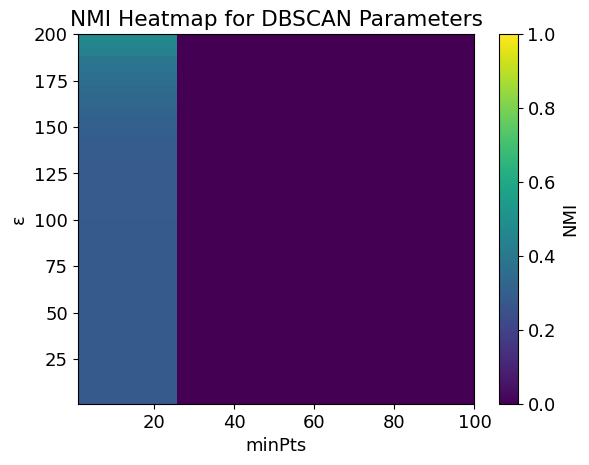

In [31]:
# Define the grid for ε and mP
eps_values = np.linspace(min_eps, max_eps, num_eps)
minPts_values = np.arange(min_minPts, max_minPts, step_minPts)

# Initialize a 2D array to store NMI values
nmi_values = np.zeros((len(eps_values), len(minPts_values)))

# Loop through the grid and compute NMI for each combination
for i, eps in enumerate(eps_values):
    for j, minPts in enumerate(minPts_values):
        dbscan = DBSCAN(eps=eps, min_samples=minPts)
        predicted_labels = dbscan.fit_predict(data)
        nmi = normalized_mutual_info_score(y, predicted_labels)
        nmi_values[i, j] = nmi

# Plot the heatmap
plt.imshow(nmi_values, extent=[min_minPts, max_minPts, min_minPts, max_eps, min_eps], aspect='auto', origin='lower')
plt.colorbar(label='NMI')
plt.clim(0, 1)  # Set color scale limits
plt.xlabel('minPts')
plt.ylabel('ε')
plt.title('NMI Heatmap for DBSCAN Parameters')
plt.show()

### 2\. Understanding the 12-dimensional data
Use the principal component analysis (PCA) to visualize the first components of the data. Does it help understand its structure?

### 3\. Compare different clustering methods
a) Perform a k-means clustering of the data, with k=3. Does it work better than DBSCAN? Why?

b) Perform a hierarchical clustering of the data and plot the corresponding dendrogram. 
Does it work better than DBSCAN?